##### Preparations

In [1]:
# If on kaggle, copy the contents of the "../input/" directory to the cwd of kaggle
def copy_if_kaggle():
    import os
    import shutil

    if os.getcwd() == "/kaggle/working":
        # Set the source directory
        src_dir = os.path.join("../input", os.listdir("../input")[0])
        # Copy all files from the source directory to the current directory
        for file_name in os.listdir(src_dir):
            shutil.copy(os.path.join(src_dir, file_name), ".")


# copy_if_kaggle()
# You can write up to 20GB to the cwd (/kaggle/working) that gets preserved as output when you push a version
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import libraries
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

# import warnings
# warnings.filterwarnings('ignore')

In [3]:
# Plot styling
def my_dark_style():
    from cycler import cycler

    plt.style.use("default")
    plt.style.use(["dark_background", "bmh"])
    plt.rcParams["axes.facecolor"] = "#23272e"
    plt.rcParams["figure.facecolor"] = "#23272e"
    plt.rcParams["axes.prop_cycle"] = cycler(
        "color",
        [
            "#1c90d4",
            "#ad0026",
            "#530fff",
            "#429900",
            "#d55e00",
            "#ff47ac",
            "#42baff",
            "#009e73",
            "#fff133",
            "#0072b2",
        ],
    )
    # plt.rcParams['figure.figsize'] = 9, 7
    plt.rcParams["figure.autolayout"] = True


box_kws = dict(
    boxprops={"edgecolor": "#b2b2b2"},
    capprops={"color": "#b2b2b2"},
    flierprops={"markeredgecolor": "#b2b2b2"},
    medianprops={"color": "#b2b2b2"},
    whiskerprops={"color": "#b2b2b2"},
)
# # plt.rcParams['boxplot.boxprops.edgecolor'] = '#b2b2b2' no such rcParam
# plt.rcParams['boxplot.capprops.color'] = '#b2b2b2'
# plt.rcParams['boxplot.flierprops.markeredgecolor'] = '#b2b2b2'
# plt.rcParams['boxplot.medianprops.color'] = '#b2b2b2'
# plt.rcParams['boxplot.whiskerprops.color'] = '#b2b2b2'

my_dark_style()

In [4]:
# Load dataset
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.name = "Train Set"
test_data.name = "Test Set"
all_data = [train_data, test_data]


def joint_data():
    return pd.concat(all_data)


# Store our passenger ID for easy access
PassengerId = test_data.pop("PassengerId")
train_data.drop(columns="PassengerId", inplace=True)

### Overview

Nominal: `Survived, Sex, Embarked, Ticket`  
Ordinal: `Pclass`  
Continous: `Age, Fare`  
Discrete: `SibSp, Parch` 

`Survived` - 0 = No, 1 = Yes  
`Pclass` is the ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd  
`SibSp` is the number of siblings / the number of spouses aboard the Titanic  
`Parch` is the number of parents / the number children aboard the Titanic  
`Embarked` is the port of embarkation	- C = Cherbourg, Q = Queenstown, S = Southampton  

In [5]:
print(train_data.info())
train_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB
None


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
168,0,1,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,NaN,S
598,0,3,"Boulos, Mr. Hanna",male,NaN,0,0,2664,7.2250,NaN,C
739,0,3,"Nankoff, Mr. Minko",male,NaN,0,0,349218,7.8958,NaN,S


In [6]:
print(test_data.info())
test_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB
None


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
264,2,"Portaluppi, Mr. Emilio Ilario Giuseppe",male,30.0,0,0,C.A. 34644,12.7375,NaN,C
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
160,3,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q


In [7]:
train_data.describe(include="all")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### Exploratory Data Analysis and Data Cleaning

In [8]:
# import matplotlib.ticker as mplticker

# for col in ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]:
#     sns.displot(
#         train_data,
#         x=col,
#         hue="Survived",
#         multiple="dodge",
#         stat="percent",
#         discrete=True,
#         shrink=0.8,
#         # common_norm=False
#     )
#     plt.gca().xaxis.set_major_locator(mplticker.MultipleLocator(1))
#     plt.show()

##### Basic visualizations

Passengers with first-class tickets had the highest survival rate, while those in third class had the lowest survival rate.

<Axes: xlabel='Pclass', ylabel='count'>

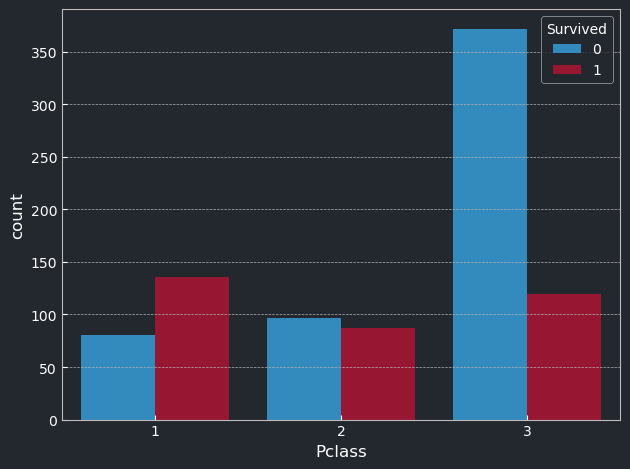

In [9]:
sns.countplot(train_data, x="Pclass", hue="Survived")

 The survival rate of females was significantly higher than that of men.

<Axes: xlabel='Sex', ylabel='count'>

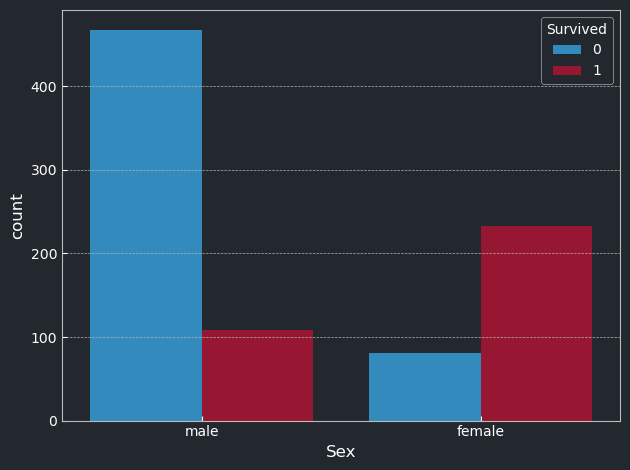

In [10]:
sns.countplot(train_data, x="Sex", hue="Survived")

 Passengers with no siblings/spouses/parents/children on board with them seem to have had a lower survival rate than those with a few companions.

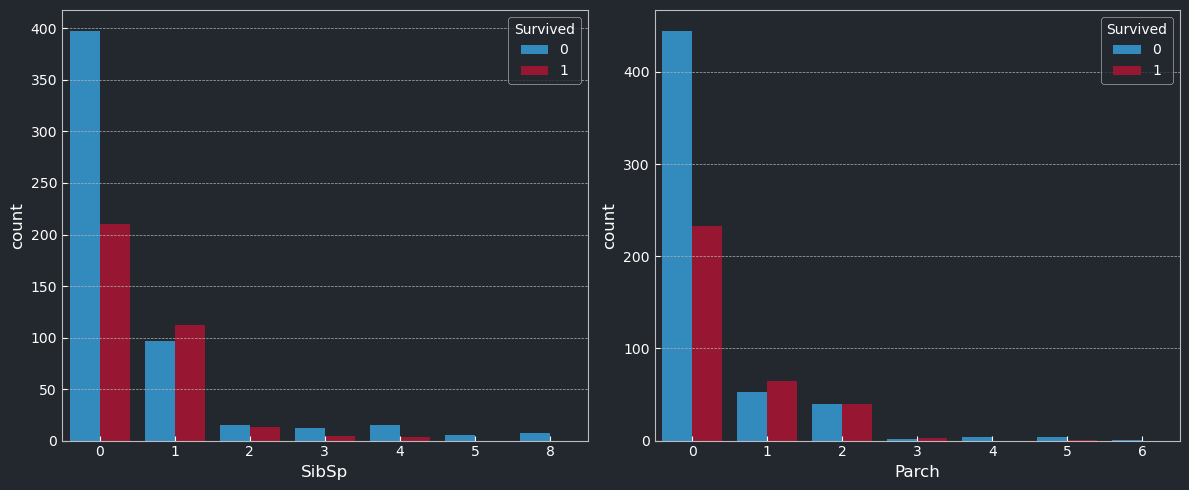

In [11]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, col in enumerate(["SibSp", "Parch"]):
    sns.countplot(train_data, x=col, hue="Survived", ax=axs[ax])

Those who embarked form the Southampton port had the lowest survival rate. Considering the numbers and order of embarkation (S->C->Q), it is also reasonable to assume that the majority of 3rd class passengers embarked form the Southampton port.

<Axes: xlabel='Embarked', ylabel='count'>

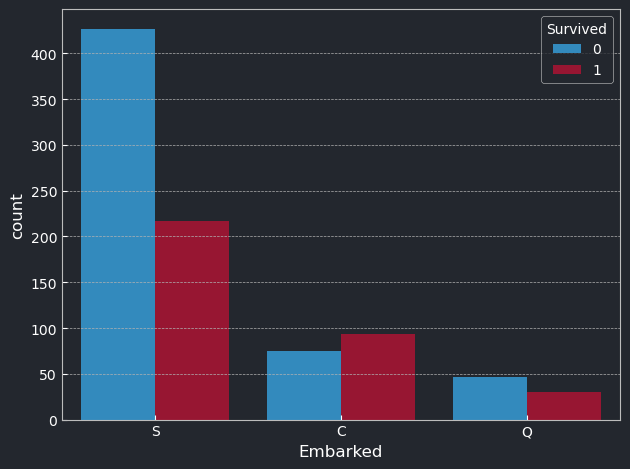

In [12]:
sns.countplot(train_data, x="Embarked", hue="Survived")

Children and elderly passengers had the highest survival rates, whereas those between the age of 20 and 30 had the lowest chance of surviving.

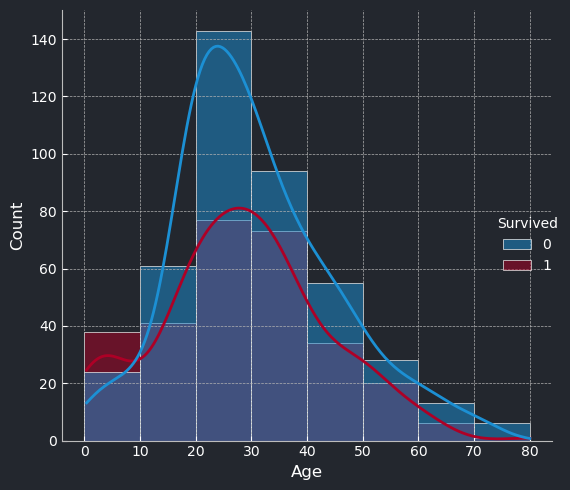

In [13]:
sns.displot(
    train_data, x="Age", hue="Survived", binwidth=10, binrange=(0, 80), kde=True
)

Those with the cheapest tickets had the lowest survival rate. The distribution is strongly skewed to the right. Most tickets costing below 10, and few cost above 100.

Text(0.5, 1.0, 'Log scale')

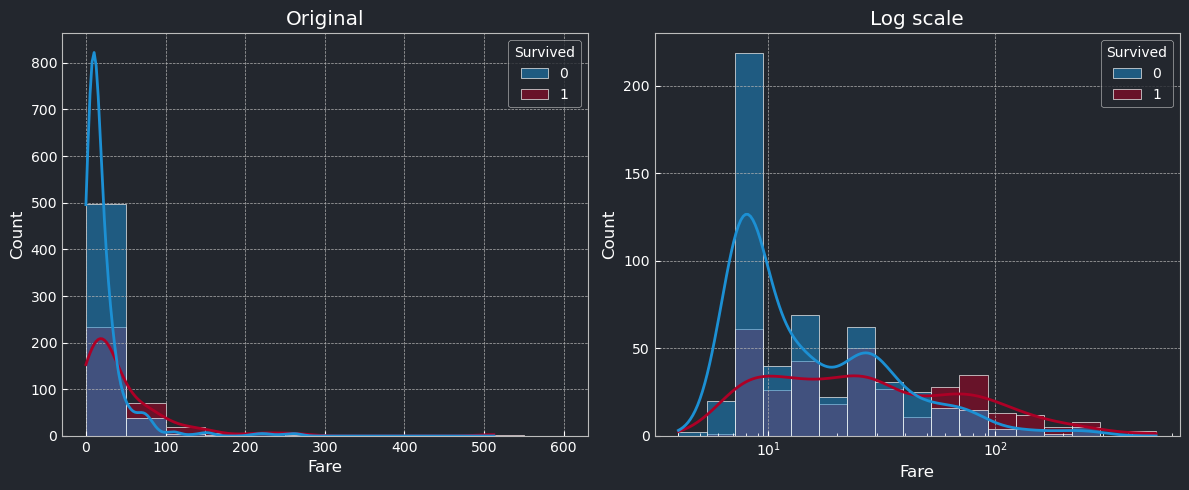

In [14]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    train_data,
    x="Fare",
    hue="Survived",
    binwidth=50,
    binrange=(0, 600),
    kde=True,
    ax=axs[0],
)
sns.histplot(
    train_data[train_data.Fare > 0],
    x="Fare",
    hue="Survived",
    log_scale=True,
    kde=True,
    ax=axs[1],
)
axs[0].set_title("Original")
axs[1].set_title("Log scale")

##### Missing values

There are missing values in the `Age, Fare, Cabin` and `Embarked` features.

In [15]:
pd.DataFrame(
    [train_data.isna().sum(), test_data.isna().sum()], index=["Train", "Test"]
).T

,Train,Test
Survived,0.0,NaN
Pclass,0.0,0.0
Name,0.0,0.0
Sex,0.0,0.0
Age,177.0,86.0
SibSp,0.0,0.0
Parch,0.0,0.0
Ticket,0.0,0.0
Fare,0.0,1.0
Cabin,687.0,327.0


There is only one passenger with a missing `Fare` value. `Fare` is related to `Pclass`, `Embarked` and family size (`Parch` and `SibSp`) features. Median `Fare` value of a third class ticket with S as the port of embarkation for a passenger with no family is a logical choice to fill the missing value with.

In [16]:
test_data[test_data["Fare"].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [17]:
# Blame black formatter for the lousy formatting..
test_data["Fare"].fillna(
    train_data.groupby(["Pclass", "Embarked", "Parch", "SibSp"]).Fare.mean()[3]["S"][0][
        0
    ],
    inplace=True,
)

It is worth noting, that some passengers have a `Fare` of 0. Ismay traveled on a complimentary ticket, as well as his servants (Fry and Harrison), Andrews and the Guarantee Group, and Reuchlin. Assuming that the rest of the passengers who hadn't paid for their tickets also received complimentary tickets, a separate 1/0 (True/False) feature `Complimentary` is created to indicate this.

In [18]:
joint_data()[joint_data().Fare == 0]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,0.0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,0.0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,0.0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,0.0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [19]:
for data in all_data:
    data["Complimentary"] = data.Fare.apply(lambda x: 1 if x == 0 else 0)
joint_data()[joint_data().Fare == 0].sample(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Complimentary
263,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,1
266,NaN,1,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0,0,112051,0.0,NaN,S,1
597,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,1


There are only 2 missing values for `Embarked`. Both passengers are upper class females from the same cabin and they have the same ticket number. In all likelihood, they are together and have embarked from the same port. A quick google search revealed the following information. *"Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was traveling in first class with her maid Amelie Icard. She occupied cabin B-28."*

In [20]:
train_data[train_data.Embarked.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Complimentary
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0


In [21]:
train_data["Embarked"].fillna("S", inplace=True)

`Age` missing values are imputed using the mean value from the nearest neighbors (using `Pclass, Sex, SibSp` and `Parch` as features, as they are likely indicators of age)

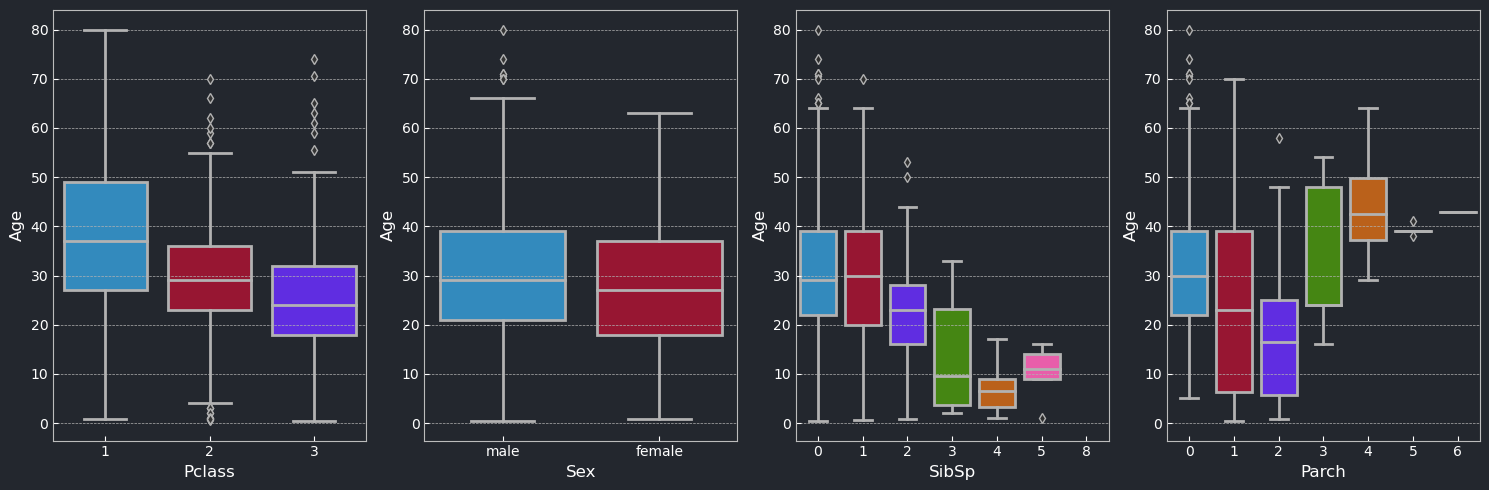

In [22]:
_, axs = plt.subplots(1, 4, figsize=(15, 5))
for ax, col in enumerate(["Pclass", "Sex", "SibSp", "Parch"]):
    sns.boxplot(
        train_data,
        x=col,
        y="Age",
        ax=axs[ax],
        # boxprops={"edgecolor": "#b2b2b2"},
        # capprops={"color": "#b2b2b2"},
        # flierprops={"markeredgecolor": "#b2b2b2"},
        # medianprops={"color": "#b2b2b2"},
        # whiskerprops={"color": "#b2b2b2"},
        **box_kws
    )

In [23]:
train_data[age_na := train_data["Age"].isna()].head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Complimentary
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0
17,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,0
19,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,0


In [24]:
neighbors = ["Age", "Pclass", "Sex", "SibSp", "Parch"]
# Encode `Sex`
ord_enc = OneHotEncoder(drop="first", sparse_output=False)
train_data["Sex"] = ord_enc.fit_transform(train_data[["Sex"]])
test_data["Sex"] = ord_enc.transform(test_data[["Sex"]])
# Scale
ss = StandardScaler()
train_data[neighbors] = ss.fit_transform(train_data[neighbors])
test_data[neighbors] = ss.transform(test_data[neighbors])
# Impute `Age`
knn_imp = KNNImputer(n_neighbors=3, weights="distance")
train_data[neighbors] = knn_imp.fit_transform(train_data[neighbors])
test_data[neighbors] = knn_imp.transform(test_data[neighbors])
# Temporarily format back to previous scale and decode `Sex` back to male/female for interpretability
for data in all_data:
    data[neighbors] = ss.inverse_transform(data[neighbors])
    data[neighbors[1:]] = data[neighbors[1:]].round().astype(int)
    data["Sex"] = ord_enc.inverse_transform(data[["Sex"]])

In [25]:
train_data[age_na].head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Complimentary
5,0,3,"Moran, Mr. James",male,25.333333,0,0,330877,8.4583,NaN,Q,0
17,1,2,"Williams, Mr. Charles Eugene",male,50.333333,0,0,244373,13.0000,NaN,S,0
19,1,3,"Masselmani, Mrs. Fatima",female,63.000000,0,0,2649,7.2250,NaN,C,0


It is possible that the only passenger in the cabin type 'T' is the captain, in which case the row could be removed from the dataset, as "the captain sinks with the ship" :3 But no, google says he's just a simple rich chum.

In [26]:
train_data.dropna()[train_data.dropna().Cabin.str.startswith("T")]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Complimentary
339,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,0


There are far too many missing `Cabin` values to meaningfully impute them, however the feature can't be ignored because some of the cabins might have higher survival rates. Another piece of interest is that some passengers had multiple cabins (all on the same deck). Those with several decks paid a significantly higher fare price. Some cabin codes are preceded by an F. It is difficult to determine what this means, but judging by the price, the F is not a separate cabin, so it is removed and treated as a single cabin due to the low number of records containing it.

In [27]:
joint_data()[
    joint_data()["Cabin"].map(lambda x: len(x.split()), na_action="ignore") > 1
].head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Complimentary
27,0.0,1,"Fortune, Mr. Charles Alexander",male,19.000000,3,2,19950,263.0000,C23 C25 C27,S,0
75,0.0,3,"Moen, Mr. Sigurd Hansen",male,25.000000,0,0,348123,7.6500,F G73,S,0
88,1.0,1,"Fortune, Miss. Mabel Helen",female,23.000000,3,2,19950,263.0000,C23 C25 C27,S,0
97,1.0,1,"Greenfield, Mr. William Bertram",male,23.000000,0,1,PC 17759,63.3583,D10 D12,C,0
118,0.0,1,"Baxter, Mr. Quigg Edmond",male,24.000000,0,1,PC 17558,247.5208,B58 B60,C,0
128,1.0,3,"Peter, Miss. Anna",female,31.333333,1,1,2668,22.3583,F E69,C,0
297,0.0,1,"Allison, Miss. Helen Loraine",female,2.000000,1,2,113781,151.5500,C22 C26,S,0
299,1.0,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.000000,0,1,PC 17558,247.5208,B58 B60,C,0
305,1.0,1,"Allison, Master. Hudson Trevor",male,0.920000,1,2,113781,151.5500,C22 C26,S,0
311,1.0,1,"Ryerson, Miss. Emily Borie",female,18.000000,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,0


In [28]:
# Remove F_ from cabin codes
for data in all_data:
    data.loc[:, "Cabin"] = data["Cabin"].map(
        (lambda x: x.replace("F ", "")), na_action="ignore"
    )

An extra feature `NCabins` is created which contains the cabin count per passenger.

In [29]:
for data in all_data:
    data.loc[:, "NCabins"] = data["Cabin"].map(
        (lambda x: len(x.split())), na_action="ignore"
    )
    data.NCabins.fillna(1, inplace=True)

In [30]:
joint_data().NCabins.value_counts()

1.0    1275
2.0      19
3.0      10
4.0       5
Name: NCabins, dtype: int64

Passengers with multiple cabins have a higher survival rate compared to those with only one cabin.

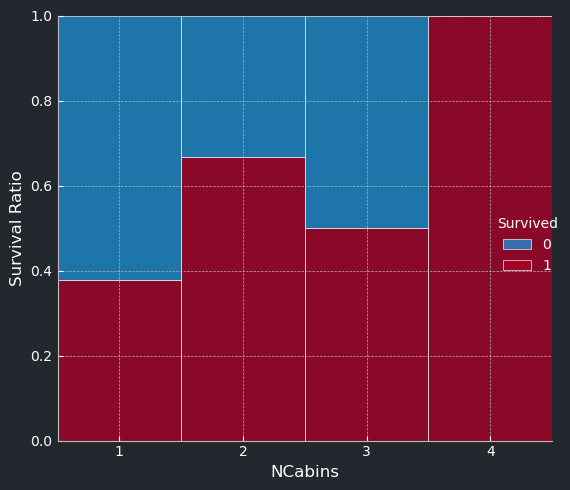

In [31]:
sns.displot(train_data, x="NCabins", hue="Survived", multiple="fill", discrete=True)
plt.ylabel("Survival Ratio")
plt.gca().xaxis.set_major_locator(mplticker.MultipleLocator(1))

In [32]:
# joint_data().groupby("Cabin", as_index=False).Ticket.nunique()[
#     joint_data()
#     .groupby("Cabin", as_index=False)
#     .Ticket.count()["Cabin"]
#     .map(lambda x: len(x.split()), na_action="ignore")
#     > 1
# ]

The first letter of each cabin code corresponds to the deck level where the cabin is located. `Deck` is extracted from the `Cabin` and the missing values simply encoded as "M". This way the missing values can be dealt with as a separate category of the `Deck` feature by the final model.

In [33]:
for data in all_data:
    data["Cabin"].fillna("M", inplace=True)
    data["Cabin"] = data.Cabin.apply(lambda x: x[0])
    data.rename(columns={"Cabin": "Deck"}, inplace=True)

In [34]:
joint_data().Deck.value_counts()

M    1014
C      94
B      65
D      46
E      44
A      22
F      14
G       9
T       1
Name: Deck, dtype: int64

`Deck` is an ordinal categorical feature. A is the topmost deck, G is the lowest passenger deck, T is the lowest deck of a ship (where the engines and boiler rooms are).  
Passengers on the middle decks B through F had the highest survival rates, whereas those on the lowest passenger deck, and those whose cabin codes are missing, had the lowest success rate. The only passenger whose cabin was on the Tank Top deck (below the Orlop Deck) did not survive.

Text(30.000000000000014, 0.5, 'Survival Ratio')

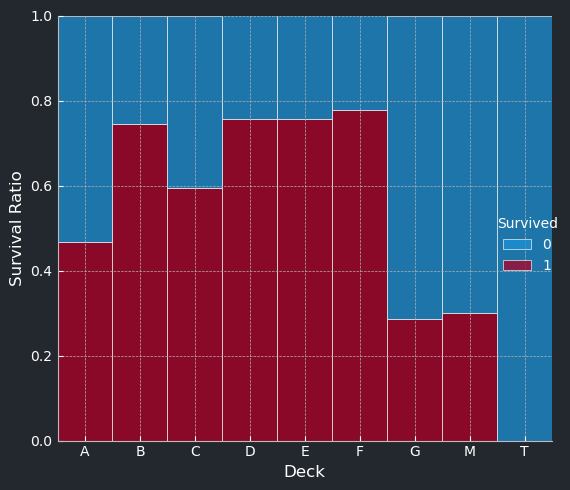

In [35]:
sns.displot(
    train_data.sort_values(by="Deck"), x="Deck", hue="Survived", multiple="fill"
)
plt.ylabel("Survival Ratio")

All missing values have been dealt with.

In [36]:
joint_data().isna().sum()

Survived         418
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Deck               0
Embarked           0
Complimentary      0
NCabins            0
dtype: int64

### Feature Engineering

`Family_Size` is created by adding `SibSp, Parch` and 1. Those who travel entirely alone don't seem to have had the highest chance of survival.

<Axes: xlabel='Family_Size', ylabel='count'>

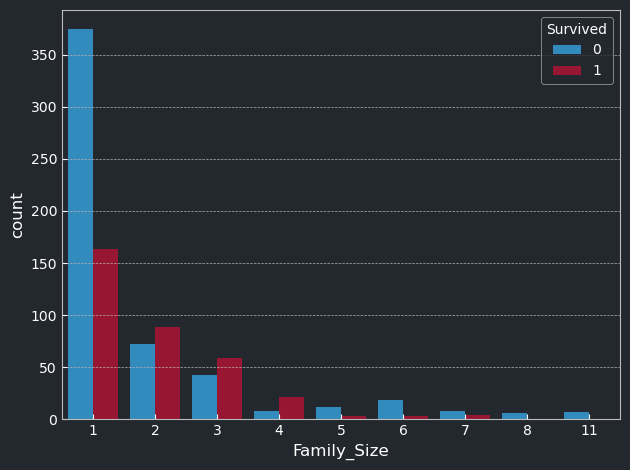

In [37]:
for data in all_data:
    data["Family_Size"] = data.SibSp + data.Parch + 1
sns.countplot(train_data, x="Family_Size", hue="Survived")

`Ticket_Freq` is created by encoding the frequency with which a ticket occurs, which gives an idea of the size of the group in which one was traveling.

<Axes: xlabel='Ticket_Freq', ylabel='count'>

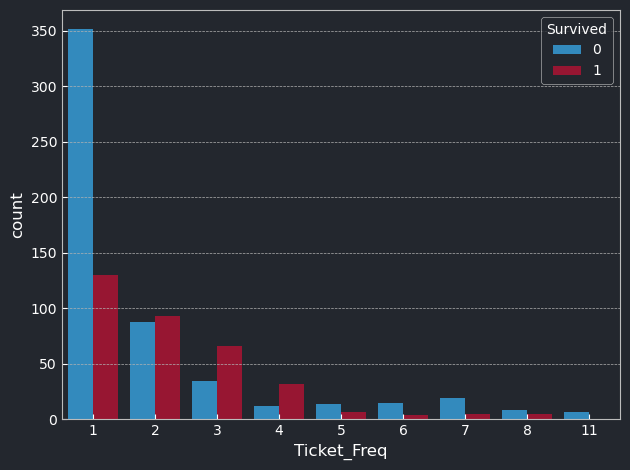

In [38]:
train_data["Ticket_Freq"] = (
    joint_data().groupby("Ticket")["Ticket"].transform("count")[:891]
)
test_data["Ticket_Freq"] = (
    joint_data().groupby("Ticket")["Ticket"].transform("count")[891:]
)
sns.countplot(train_data, x="Ticket_Freq", hue="Survived")

In a similar manner, `Family_Freq` is created. First the surname is extracted from the name, and then the frequency with which a surname occurs is encoded.

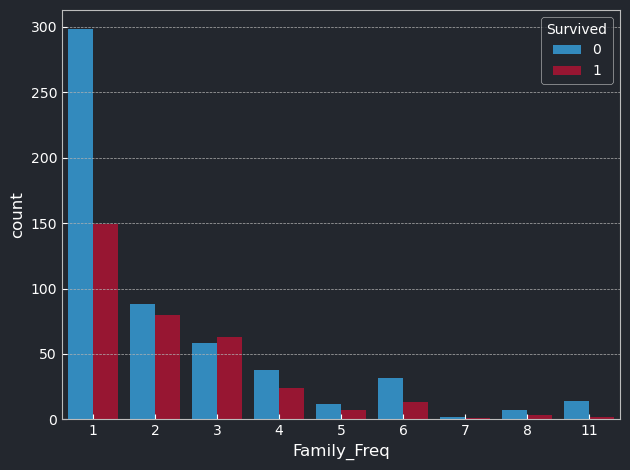

In [41]:
def extract_surname(name):
    if "(" in name:
        name_no_bracket = name.split("(")[0]
    else:
        name_no_bracket = name
    family = name_no_bracket.split(",")[0]
    return family


for data in all_data:
    data["Name"] = data.Name.apply(extract_surname)
train_data["Family_Freq"] = (
    joint_data().groupby("Name")["Name"].transform("count")[:891]
)
test_data["Family_Freq"] = joint_data().groupby("Name")["Name"].transform("count")[891:]
sns.countplot(train_data, x="Family_Freq", hue="Survived")